In [1]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import matplotlib.image
import matplotlib.animation as animation
#%matplotlib qt

import os
import glob


import torch
import torchvision.transforms as T

from geometric_transforms.utils import plot, plot_von_mises, plot_animation, rm_arrays_imgs
from geometric_transforms.random_motion import brownian, ornstein_uhlenbeck

from torchvision.transforms import InterpolationMode

from geometric_transforms.transforms import generate_affine, get_perspectives, interpolate_affine_params, interpolate_perspectives



In [2]:
np.random.seed(2023)

def generate_random_texture(width, height, check_size=16, max_value = 16):
    # Calculate the number of checkers in each dimension
    num_checkers_x = width // check_size
    num_checkers_y = height // check_size
    
    # Create a blank image with the given dimensions
    texture = np.zeros((height, width), dtype=np.uint8)
    
    # Iterate over the checkers and set each one to a random value between 0 and 255
    #print(num_checkers_y)
    #print(num_checkers_x)
    for y in range(num_checkers_y):
        for x in range(num_checkers_x):
            value = np.random.randint(max_value)
            checker = np.full((check_size, check_size), value, dtype=np.uint8)
            texture[y*check_size:(y+1)*check_size, x*check_size:(x+1)*check_size] = checker
            
            
    return texture


def generate_subsampled_texture(width, height, check_size=14, min_value = 0, max_value=255, step=20):
    # Calculate the number of checkers in each dimension
    num_checkers_x = width // check_size
    num_checkers_y = height // check_size
    
    # Create a blank image with the given dimensions
    texture = np.zeros((height, width), dtype=np.uint8)
    
    # Create the set of values to use in the texture
    values = np.arange(min_value, max_value + 1, step, dtype=np.uint8)
    
    # Iterate over the checkers and set each one to a random value from the set of values
    for y in range(num_checkers_y):
        for x in range(num_checkers_x):
            value = np.random.choice(values)
            checker = np.full((check_size, check_size), value, dtype=np.uint8)
            texture[y*check_size:(y+1)*check_size, x*check_size:(x+1)*check_size] = checker
    
    return texture


# 8 values = 256/32 and max_value = 256 = 255 + 1
#
size_texture = 864
TEXTURE = generate_subsampled_texture(size_texture*2, size_texture*2, check_size=14, max_value= 255, step= 255)

#TEXTURE = generate_random_texture(864*2, 864*2, check_size=14*2)

In [3]:
#plt.hist(TEXTURE)

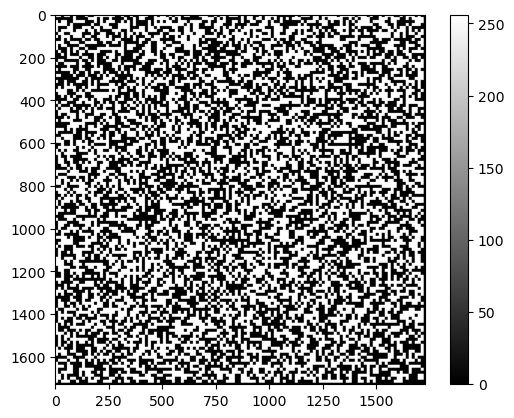

In [4]:
plt.imshow(TEXTURE, cmap = "gray",vmin = 0, vmax = 256)
plt.colorbar()

In [5]:
np.unique(TEXTURE)

array([  0, 255], dtype=uint8)

In [6]:
TEXTURE.dtype

dtype('uint8')

## Perspectives
### 1st Set : 15 imgs repeated 100 times

In [24]:
np.random.seed(2023);
torch.manual_seed(0);

In [3]:
SIZE = 15
perspective_list = get_perspectives(TEXTURE.shape[0], TEXTURE.shape[1], distortion_scale= 0.5, N = SIZE)
perspective_list.append(perspective_list[0])

In [4]:
n_frames = 20
pers_int_list =[]
for i in range(0, SIZE + 1):
    
    interpolated_list = interpolate_perspectives(perspective_list[i], perspective_list[(i+1)], n_frames = n_frames)
    pers_int_list.extend(interpolated_list)
    

In [10]:
#repetitions_ = 100
#pers_int_list = pers_int_list*repetitions_

In [5]:
imagelist = []
for i in tqdm(range(len(pers_int_list) -1)):
    
    ### INTERPOLATION NEAREST !!!!! 
    img_ = np.asarray(T.functional.perspective(Image.fromarray(TEXTURE), pers_int_list[0], pers_int_list[i+1], 
                                               interpolation = InterpolationMode.NEAREST)) 
    
    imagelist.append(img_[int(size_texture/2): img_.shape[0] - int(size_texture/2), int(size_texture/2):img_.shape[1] - int(size_texture/2)])

100%|██████████| 319/319 [00:03<00:00, 103.33it/s]


319
<class 'numpy.ndarray'>


dtype('uint8')

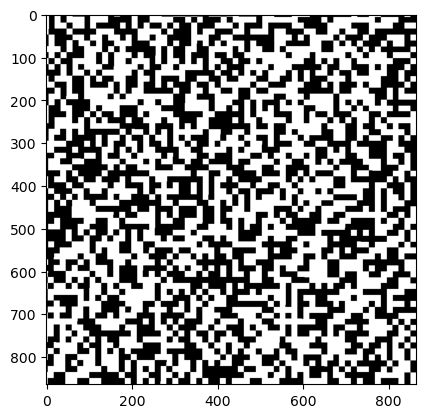

In [19]:
print((len(imagelist)))
imagelist[0].shape
plt.imshow(imagelist[0], cmap = "gray",vmin = 0, vmax = 256)
print(type(imagelist[0]))
imagelist[0].dtype


In [6]:
N_REPETITIONS = 30
print("minutes: " + str(len(imagelist)/30/60*N_REPETITIONS))

minutes: 5.316666666666666


In [ ]:
# %matplotlib qt
# plot_animation(imagelist)

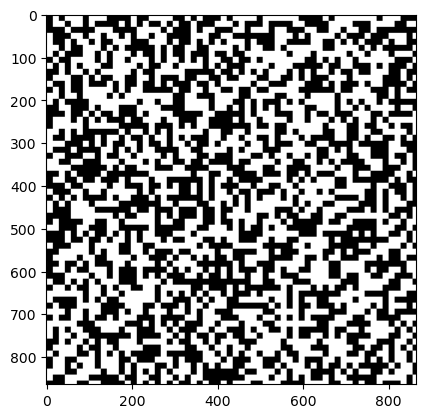

In [9]:
anim_ = plot_animation(imagelist)
anim_.save("example_perspecttive.gif")

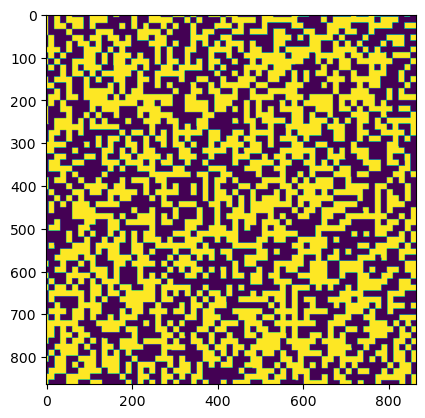

In [8]:
im_array_seq = np.asarray(imagelist)
plt.imshow(im_array_seq[0])

In [17]:
np.unique(im_array_seq)

array([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96,
       104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200,
       208, 216, 224, 232, 240, 248], dtype=uint8)

In [9]:
# np.save("8_values/MEA2/size_500/15_imgs.npy", im_array_seq) 
np.save("saved_bins/15_imgs.npy", im_array_seq) 

### 2nd Set: Repetitions with different textures

In [14]:
torch.manual_seed(0);

In [42]:
SIZE = 6
perspective_list = get_perspectives(TEXTURE.shape[0], TEXTURE.shape[1], distortion_scale= 0.5, N = SIZE)
perspective_list.append(perspective_list[0])

In [43]:
perspective_list

[[[0, 0], [1727, 0], [1727, 1727], [0, 1727]],
 [[159, 101], [1554, 70], [1551, 1654], [136, 1650]],
 [[22, 177], [1698, 1], [1643, 1727], [96, 1551]],
 [[1, 68], [1551, 106], [1557, 1542], [132, 1691]],
 [[3, 59], [1684, 177], [1577, 1673], [1, 1727]],
 [[85, 1], [1727, 35], [1727, 1542], [129, 1680]],
 [[177, 225], [1602, 140], [1571, 1551], [177, 1600]],
 [[0, 0], [1727, 0], [1727, 1727], [0, 1727]]]

In [16]:
n_frames = 20
pers_int_list =[]
for i in range(0, SIZE + 1):
    
    interpolated_list = interpolate_perspectives(perspective_list[i], perspective_list[(i+1)], n_frames = n_frames)
    pers_int_list.extend(interpolated_list)
    

In [21]:
textures = []

for i in range(0,SIZE + 1):
    np.random.seed(2023 + i)
    
    #TEXTURE = np.uint8(np.random.randint(0, 255, size = (864//4, 864//4)))
    #TEXTURE = Image.fromarray(TEXTURE).resize((864*2,864*2 ))
    #TEXTURE.save("imgs/gaussian_noise.png", "PNG")
    #TEXTURE = np.array(TEXTURE)
    #TEXTURE = generate_random_texture(864*2, 864*2, check_size=14*2)
    TEXTURE = generate_subsampled_texture(size_texture*2, size_texture*2, check_size=14, max_value= 255, step= 255)
    textures.append(TEXTURE)
    #np.save('imgs/gaussian_noise.png', TEXTURE)

    
#textures.append(textures[0])

In [22]:
imagelist = []
counter = 0 

for text_ in tqdm(textures): 
    for i in range(len(pers_int_list) -1):
    
        #text_ = textures[counter]
 
        img_ = np.asarray(T.functional.perspective(Image.fromarray(text_), pers_int_list[0], pers_int_list[i+1], 
                                               interpolation = InterpolationMode.NEAREST)) 
        imagelist.append(img_[int(size_texture/2): img_.shape[0] - int(size_texture/2), 
                              int(size_texture/2):img_.shape[1] - int(size_texture/2)])

        #if i > 0 and i % 20 == 0: 
        #    counter = counter + 1
    
    
    #imagelist.append(img_)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.37s/it]


In [23]:
N_REPETITIONS = 30
print("minutes: " + str(len(imagelist)/30/60*N_REPETITIONS))

minutes: 16.216666666666665


In [24]:
%matplotlib qt
plot_animation(imagelist)

In [25]:
im_array_seq = np.asarray(imagelist)

In [26]:
np.unique(im_array_seq[0,:,:])

array([  0, 255], dtype=uint8)

In [62]:
#np.save("8_values/MEA2/6_imgs_diff_textures.npy", im_array_seq) 

### 3rd Set: Random succession of images

In [204]:
np.random.seed(2023)
#TEXTURE = generate_random_texture(864*2, 864*2, check_size=14*2)
#TEXTURE = generate_subsampled_texture(864*2, 864*2, check_size=14*2, min_value = 248,  max_value= 255, step=1)
TEXTURE = generate_subsampled_texture(size_texture*2, size_texture*2, check_size=14, max_value= 255, step= 8)
SIZE = 1000
n_frames = 20 #interpolation frames

In [205]:
plt.imshow(TEXTURE, cmap = 'gray')

In [206]:
np.unique(TEXTURE)

array([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96,
       104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200,
       208, 216, 224, 232, 240, 248], dtype=uint8)

In [207]:
for rnd_seed in tqdm(range(0, 9)):
    
    np.random.seed(2023 + rnd_seed )
    torch.manual_seed(2023 + rnd_seed)

    perspective_list = get_perspectives(TEXTURE.shape[0], TEXTURE.shape[1], distortion_scale= 0.5, N = SIZE)
    perspective_list.append(perspective_list[0])

    pers_int_list =[]
    for i in range(0, SIZE + 1):

        interpolated_list = interpolate_perspectives(perspective_list[i], perspective_list[(i+1)], n_frames = n_frames)
        pers_int_list.extend(interpolated_list)
        
        
    imagelist_long = []
    for i in range(len(pers_int_list) -1):
 
        img_ = np.asarray(T.functional.perspective(Image.fromarray(TEXTURE), pers_int_list[0], pers_int_list[i+1], 
                                               interpolation = InterpolationMode.NEAREST)) 
        imagelist_long.append(img_[int(size_texture/2): img_.shape[0] - int(size_texture/2),
                                   int(size_texture/2):img_.shape[1] - int(size_texture/2)])
        
        
    im_array_seq_1000_set = np.array(imagelist_long)
    np.save("8_values/MEA2/size_500/1000_imgs_set_"+str(rnd_seed + 1)+".npy", im_array_seq_1000_set)
    
    del imagelist_long
    del im_array_seq_1000_set

100%|█████████████████████████████████████████████| 9/9 [10:02<00:00, 66.93s/it]


### EXPORT Short

In [10]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from bin_manipulation import BinFile
from pystim.images.png import load as load_png_image
from pystim.io.bin import open_file as open_bin_file

In [11]:
size_texture = 864
dimension= size_texture
gray_ind=0 # Position of the gray frame (better in first position = index 0)

n_bits= 8 
n_patterns = 2**n_bits-1

#n_to_repeat=30  # Number of natural images to be repeated in the stimulus
#nat_repeat=30   # Number of times these natural images are repeated in the stimulus
#blurred_repeat=25   # Number of times the blurred images are repeated in the stimulus

#im_dur=25#ms    How long the images are presented in the stimulus
#gray_dur = #ms  How ong the gray frames are presented in the stimulus
#gray_dur_init=0#ms   How long the first gray frame is presented in the stimulus

#freq=40#Hz  The frequency of the stimulus

In [26]:
im_array_seq.shape
# plt.imshow(im_array_seq[100,:,:], cmap = 'gray')
# plt.show()

(319, 864, 864)

In [12]:
im_array_seq.shape

(319, 864, 864)

In [36]:
bin_path='saved_bins/15_imgs.npy'

bin_file = open_bin_file(bin_path,
                         im_array_seq.shape[0],
                         dimension,
                         dimension,
                         reverse=False,
                         mode='w')


header_list: [864, 864, 319, 8]


In [37]:
im_array_seq[0]


array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [38]:
print("Adding the original natural images to the .bin file...")
for ref in tqdm(range(0, im_array_seq.shape[0])):
    #temp_im_num=ref[0]
    #temp_im_name=ref[-1]
    #temp_im_path='/'.join((nat_folder,temp_im_name))
    # temp_im=skimage.io.imread(temp_im_path)
    #temp_im=load_png_image(temp_im_path)
    temp_im = im_array_seq[ref, :, :]
    bin_file.append(temp_im)
    # im_list[ref_list.index(ref),:,:]=temp_im.data[:,:]
    

bin_file.close()

print("Finished creating the .bin file.")

Adding the original natural images to the .bin file...


100%|██████████| 319/319 [00:00<00:00, 3474.24it/s]

Finished creating the .bin file.


In [40]:
def open_file(path, nb_images=0, frame_width=size_texture, frame_height=size_texture, reverse=False, mode='r'):

    file = BinFile(path, nb_images, frame_width, frame_height, reverse=reverse, mode=mode)

    return file

In [41]:
bin_check = open_file("saved_bins/15_imgs.npy")

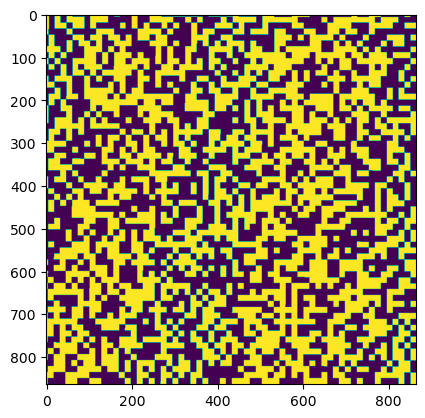

In [43]:
a=bin_check.read_frame(0)
plt.imshow(a)

In [181]:
repetitions_ = 30
idxs_ = [i for i in range(0, im_array_seq.shape[0])]
idxs_ = idxs_*repetitions_

In [182]:
## vec file ]
# We save the stimulus in a .vec file 

NbFrames= im_array_seq.shape[0]*repetitions_

vec=np.empty((NbFrames+1,5),dtype = np.uint )
vec[0,:]=[0, NbFrames, 0, 0, 0]
vec[1:,:]=0
vec[1:,1] = idxs_


In [183]:
print(NbFrames)
print(len(vec))
out_path = "8_values/MEA2/size_500/15_imgs"

with open("{}.vec".format(out_path),"w") as f:
    np.savetxt(f,vec, delimiter=',', fmt='%i %i %i %i %i')


9570
9571


In [184]:
print("minutes: " + str(9571/30/60))

minutes: 5.317222222222223


## Export Short w/ Different Textures

In [65]:
bin_path='8_values/MEA2/6_imgs_diff_textures.bin'

bin_file = open_bin_file(bin_path,
                         im_array_seq.shape[0],
                         dimension,
                         dimension,
                         
                         reverse=False,
                         mode='w')


header_list: [864, 864, 973, 8]


In [66]:
print("Adding the original natural images to the .bin file...")
for ref in tqdm(range(0, im_array_seq.shape[0])):
    #temp_im_num=ref[0]
    #temp_im_name=ref[-1]
    #temp_im_path='/'.join((nat_folder,temp_im_name))
    # temp_im=skimage.io.imread(temp_im_path)
    #temp_im=load_png_image(temp_im_path)
    temp_im = im_array_seq[ref, :, :]
    bin_file.append(temp_im)
    # im_list[ref_list.index(ref),:,:]=temp_im.data[:,:]
    
    

bin_file.close()

print("Finished creating the .bin file.")

Adding the original natural images to the .bin file...


100%|███████████████████████████████████████| 973/973 [00:00<00:00, 4049.25it/s]


Finished creating the .bin file.


In [69]:
def open_file(path, nb_images=0, frame_width=864, frame_height=864, reverse=False, mode='r'):

    file = BinFile(path, nb_images, frame_width, frame_height, reverse=reverse, mode=mode)

    return file

In [70]:
bin_check = open_file('8_values/MEA2/6_imgs_diff_textures.bin')

In [71]:
a=bin_check.read_frame(0)
plt.imshow(a)

In [72]:
repetitions_ = 30
idxs_ = [i for i in range(0, im_array_seq.shape[0])]
idxs_ = idxs_*repetitions_

In [73]:
## vec file 
# We save the stimulus in a .vec file 

NbFrames= im_array_seq.shape[0]*repetitions_

vec=np.empty((NbFrames+1,5),dtype = np.uint )
vec[0,:]=[0, NbFrames, 0, 0, 0]
vec[1:,:]=0
vec[1:,1] = idxs_


In [74]:
print(NbFrames)
print(len(vec))
out_path = "8_values/MEA2/6_imgs_diff_textures"

with open("{}.vec".format(out_path),"w") as f:
    np.savetxt(f,vec, delimiter=',', fmt='%i %i %i %i %i')


29190
29191


In [75]:
print("minutes: " + str(29191/30/60))

minutes: 16.217222222222222


### Export long

In [232]:
im_array_seq_500_sets = np.empty((20019*3, size_texture, size_texture), dtype = np.uint8)

for i in tqdm(range(1,4)):
    #im_array_seq_500_set = np.load("8_values/MEA2/size_500/1000_imgs_set_" + str(i) + ".npy")
    #im_array_seq_500_set = np.load("8_values/MEA2/size_500/1000_imgs_set_" + str(i+3) + ".npy")
    im_array_seq_500_set = np.load("8_values/MEA2/size_500/1000_imgs_set_" + str(i+6) + ".npy")
    
    im_array_seq_500_sets[20019*(i-1):20019*i, :, :] = im_array_seq_500_set

100%|█████████████████████████████████████████████| 3/3 [00:09<00:00,  3.04s/it]


In [233]:
#im_array_seq_500_set1.shape

In [234]:
dimension= size_texture
gray_ind=0 # Position of the gray frame (better in first position = index 0)

n_bits= 8 
n_patterns = 2**n_bits-1


In [235]:
#bin_path='8_values/MEA2/size_500/1000_imgs_sets_first_part.bin'
#bin_path='8_values/MEA2/size_500/1000_imgs_sets_second_part.bin'
bin_path='8_values/MEA2/size_500/1000_imgs_sets_third_part.bin'

bin_file = open_bin_file(bin_path,
                         im_array_seq_500_sets.shape[0],
                         dimension,
                         dimension,
                         
                         reverse=False,
                         mode='w')


header_list: [500, 500, 60057, 8]


In [236]:
print("Adding the original natural images to the .bin file...")
for ref in tqdm(range(0, im_array_seq_500_sets.shape[0])):
    #temp_im_num=ref[0]
    #temp_im_name=ref[-1]
    #temp_im_path='/'.join((nat_folder,temp_im_name))
    # temp_im=skimage.io.imread(temp_im_path)
    #temp_im=load_png_image(temp_im_path)
    temp_im = im_array_seq_500_sets[ref, :, :]
    bin_file.append(temp_im)
    # im_list[ref_list.index(ref),:,:]=temp_im.data[:,:]
    
    

bin_file.close()

print("Finished creating the .bin file.")

Adding the original natural images to the .bin file...


100%|██████████████████████████████████| 60057/60057 [00:05<00:00, 11491.89it/s]


Finished creating the .bin file.


In [237]:
def open_file(path, nb_images=0, frame_width=size_texture, frame_height=size_texture, reverse=False, mode='r'):

    file = BinFile(path, nb_images, frame_width, frame_height, reverse=reverse, mode=mode)

    return file

In [238]:
bin_check = open_file(bin_path)

In [226]:
#22*10**(-6)*3721*50

In [239]:
a=bin_check.read_frame(0)
plt.imshow(a, cmap = "gray")
plt.colorbar()

In [240]:
#repetitions_ = 150
idxs_ = [i for i in range(0, im_array_seq_500_sets.shape[0])]
#idxs_ = idxs_*repetitions_

In [241]:
## vec filspaced_range/]
# We save the stimulus in a .vec file 

NbFrames= im_array_seq_500_sets.shape[0]#*repetitions_

vec=np.empty((NbFrames+1,5),dtype = np.uint )
vec[0,:]=[0, NbFrames, 0, 0, 0]
vec[1:,:]=0
vec[1:,1] = idxs_


In [242]:
print(NbFrames)
print(len(vec))
#out_path = "8_values/MEA2/size_500/1000_imgs_sets_first_part"
#out_path = "8_values/MEA2/size_500/1000_imgs_sets_second_part"
out_path = "8_values/MEA2/size_500/1000_imgs_sets_third_part"

with open("{}.vec".format(out_path),"w") as f:
    np.savetxt(f,vec, delimiter=',', fmt='%i %i %i %i %i')

60057
60058


In [243]:
print("minutes:" + str(60058/30/60))

minutes:33.36555555555556
